In [1]:
# Import dependancies
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, ZeroPadding2D, Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import os

In [2]:
# Check CPU or GPU using by tensorflow
cpus = tf.config.list_physical_devices('CPU')
print(cpus)

gpus = tf.config.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Limit driver usage
tf.config.threading.set_intra_op_parallelism_threads(10)
tf.config.threading.set_inter_op_parallelism_threads(10)

if gpus:
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [4]:
# Path of the different folders
train_path = './chest_Xray/train'
test_path = './chest_Xray/test'

# Fixe images size
IMAGE_SIZE = 224
batch_size = 8

# List different labels
labels=['NORMAL', 'PNEUMONIA']

In [5]:
train_gen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    validation_split=.2,
)

train_batches = train_gen.flow_from_directory(
    train_path, 
    target_size = (IMAGE_SIZE, IMAGE_SIZE), 
    batch_size = batch_size,
    class_mode = "categorical",
    subset='training'
)

gen = ImageDataGenerator(
    rescale = 1./255,
    validation_split=.2,
)

val_batches = gen.flow_from_directory(
    train_path, 
    target_size = (IMAGE_SIZE, IMAGE_SIZE), 
    batch_size = batch_size,
    class_mode = "categorical",
    subset='validation'
)

test_batches = gen.flow_from_directory(
    test_path, 
    target_size = (IMAGE_SIZE, IMAGE_SIZE), 
    batch_size = batch_size,
    class_mode = "categorical",
)

print(train_batches.image_shape)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
(224, 224, 3)


In [6]:
# VGG16 Model
vgg = VGG16(
    input_shape = [IMAGE_SIZE, IMAGE_SIZE, 3],
    weights = 'imagenet',
    include_top=False
)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output)
x = Dense(1000, activation='relu')(x)

# This is the Last Layer with softmax activation for binary outputs
prediction = Dense(len(labels), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# View the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
model.compile(
    loss="categorical_crossentropy", 
    metrics=["accuracy"], 
    optimizer=keras.optimizers.Adam(learning_rate = 0.0001)
)

checkpoint = keras.callbacks.ModelCheckpoint(
    './ZoidbergVGG16.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True, 
    mode = 'auto'
)

history = model.fit(
    train_batches, 
    validation_data=val_batches, 
    epochs=10, 
    callbacks=[checkpoint],
)

Epoch 1/10
522/522 [==============================] - ETA: 0s - loss: 0.2129 - accuracy: 0.9171
Epoch 1: val_loss improved from inf to 0.29468, saving model to ./ZoidbergVGG16.h5
522/522 [==============================] - 54s 100ms/step - loss: 0.2129 - accuracy: 0.9171 - val_loss: 0.2947 - val_accuracy: 0.8869
Epoch 2/10
522/522 [==============================] - ETA: 0s - loss: 0.1214 - accuracy: 0.9538
Epoch 2: val_loss improved from 0.29468 to 0.07428, saving model to ./ZoidbergVGG16.h5
522/522 [==============================] - 51s 97ms/step - loss: 0.1214 - accuracy: 0.9538 - val_loss: 0.0743 - val_accuracy: 0.9703
Epoch 3/10
522/522 [==============================] - ETA: 0s - loss: 0.1125 - accuracy: 0.9576
Epoch 3: val_loss did not improve from 0.07428
522/522 [==============================] - 50s 96ms/step - loss: 0.1125 - accuracy: 0.9576 - val_loss: 0.6387 - val_accuracy: 0.7689
Epoch 4/10
522/522 [==============================] - ETA: 0s - loss: 0.1083 - accuracy: 0.9581

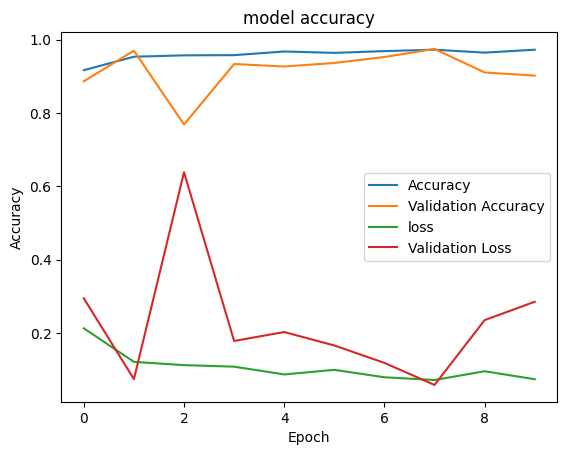

In [8]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [9]:
final_model = keras.models.load_model('./ZoidbergVGG16.h5')

In [10]:
pred = final_model.predict(test_batches)
pred_final = np.argmax(pred, axis=1)

In [11]:
print(classification_report(test_batches.classes, pred_final, target_names=labels))

              precision    recall  f1-score   support

      NORMAL       0.31      0.23      0.26       234
   PNEUMONIA       0.60      0.70      0.65       390

    accuracy                           0.52       624
   macro avg       0.46      0.46      0.45       624
weighted avg       0.49      0.52      0.50       624



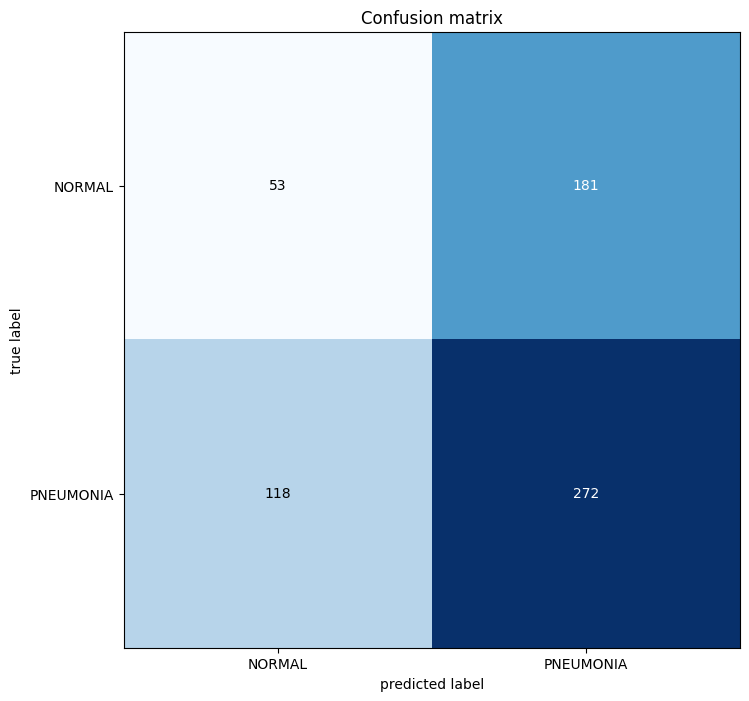

In [12]:
CM = confusion_matrix(test_batches.classes, pred_final)

fig, ax = plot_confusion_matrix(conf_mat = CM ,  figsize = (8,8))
plt.title('Confusion matrix')
plt.xticks(range(2), labels, fontsize = 10)
plt.yticks(range(2), labels, fontsize = 10)
plt.show()